In [2]:
import numpy as np
import optuna
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
%load_ext autoreload
%autoreload 2


In [3]:
def plot_with_sliding_window_variance(ax, x, y, xlabel, ylabel, title, window_size=5):
    # Ensure x, y are numpy arrays for easier manipulation
    x, y = np.array(x), np.array(y)
    
    # Scatter plot
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    
    # Sort x and y by x to ensure correct plotting
    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]
    if len(x) < 5:
        ax.legend(['models'])
        return
    # Linear fit
    slope, intercept = np.polyfit(x, y, 1)
    fit_line = np.polyval([slope, intercept], x)
    ax.plot(x, fit_line, color='red')
    if len(x) > 5:
        # Calculate variance with a sliding window
        variance = np.array([np.var(y[max(0, i-window_size//2):min(len(y), i+window_size//2)]) for i in range(len(y))])
        sigma = np.sqrt(variance)
        
        # Smooth the variance to avoid overly noisy bands
        sigma_smoothed = savgol_filter(sigma, window_length=min(100, len(x) - 1 if len(x) % 2 == 0 else len(x)), polyorder=3)
        
        # Plot sliding window variance (confidence interval) around the line
        ax.fill_between(x, fit_line - sigma_smoothed, fit_line + sigma_smoothed, color='red', alpha=0.2)

        ax.legend(['models', 'trend', 'variance'])
    else:
        ax.legend(['models', 'trend'])

def bar_encoder(ax, encoders, encoder_positions, *args, skip_labels=False):
    n_bars = len(args)
    n_groups = len(encoders)
    width = 0.8 / n_bars  # Calculate the width for each bar

    # Iterate through each metric provided
    for i, (metric, label) in enumerate(args):
        averages = []  # Store average metric values
        error = []  # Store min and max relative to the mean for error bars
        max_vals = []

        # Calculate statistics for each encoder
        for encoder in encoders:
            mask = encoder_positions == encoder
            filtered_metric = metric[mask]
            mean_val = np.mean(filtered_metric)
            averages.append(mean_val)
            # Calculate errors as distances from the mean to the min and max values
            min_val = np.min(filtered_metric)
            max_val = np.max(filtered_metric)
            error.append([mean_val - min_val, max_val - mean_val])
            max_vals.append(max_val)
        
        # Calculate positions for the current set of bars
        positions = np.arange(len(encoders)) + i * width
        
        # Plot the bars with modified error bars representing the min to max range
        bars = ax.bar(positions, averages, width, label=label, alpha=0.7)
        # Add error bars for min and max values
        error = np.array(error).T  # Transpose to match the expected shape for error bars
        ax.errorbar(positions, averages, yerr=error, fmt='none', ecolor='black', capsize=5, alpha=0.7, label='min to max')
        # Annotate each bar with min and max values
        for bar, avg, maximum in zip(bars, averages, max_vals):
            if avg == maximum:
                ax.annotate(f'{maximum:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)
            else:
                ax.annotate(f'Max: {maximum:.2f}\nAvg: {avg:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

    ax.set_xticks(np.arange(n_groups) + width * (n_bars - 1) / 2)
    # ax.set_xticklabels([f'{encoder}\nsamples: {np.sum([encoder_positions == encoder])}' for encoder in encoders], rotation=15)
    if not skip_labels:
        ax.set_xticklabels([e.replace("_", "_\n").replace(".", ".\n") for e in encoders])
    ax.legend()

In [9]:
study_name = "sub"
db = "sqlite:///optuna_v2.db"
storage = optuna.storages.RDBStorage(url=db)
study_names = list(map(lambda x: x.study_name, storage.get_all_studies()))
study_names

['subVPSDE', 'VPSDE', 'VESDE']

In [17]:
trials = []
for sn  in study_names:
    if sn.startswith(study_name):
        study = optuna.load_study(study_name=sn, storage=storage)
        trials += study.trials

print(f"loaded {len(trials)} trials")


values = list([t.user_attrs | t.params |{"auc": (t.values[1] + t.values[2])/2} for t in trials if t.values is not None])
print(len(values), len(trials))

loaded 449 trials
415 449


In [18]:
values

[{'deit_imagenet_farood_inaturalist_AUC': 0.867141675,
  'deit_imagenet_farood_inaturalist_FPR_95': 0.7859,
  'deit_imagenet_farood_inaturalist_score_ood': 9.333244323730469,
  'deit_imagenet_farood_openimageo_AUC': 0.8658752949183303,
  'deit_imagenet_farood_openimageo_FPR_95': 0.7202245916515426,
  'deit_imagenet_farood_openimageo_score_ood': 9.342456817626953,
  'deit_imagenet_farood_textures_AUC': 0.8313175813953488,
  'deit_imagenet_farood_textures_FPR_95': 0.7782945736434108,
  'deit_imagenet_farood_textures_score_ood': 9.248199462890625,
  'deit_imagenet_id_AUC': 0.44046368915,
  'deit_imagenet_id_FPR95': 0.98102,
  'deit_imagenet_id_loss': 98.06859557322967,
  'deit_imagenet_nearood_imagenet-o_AUC': 0.75880244,
  'deit_imagenet_nearood_imagenet-o_FPR_95': 0.9045,
  'deit_imagenet_nearood_imagenet-o_score_ood': 9.04420280456543,
  'deit_imagenet_score_id': 8.350279808044434,
  'deit_imagenet_score_ref': 8.484925270080566,
  'dino_imagenet_farood_inaturalist_AUC': 0.865285883,
  

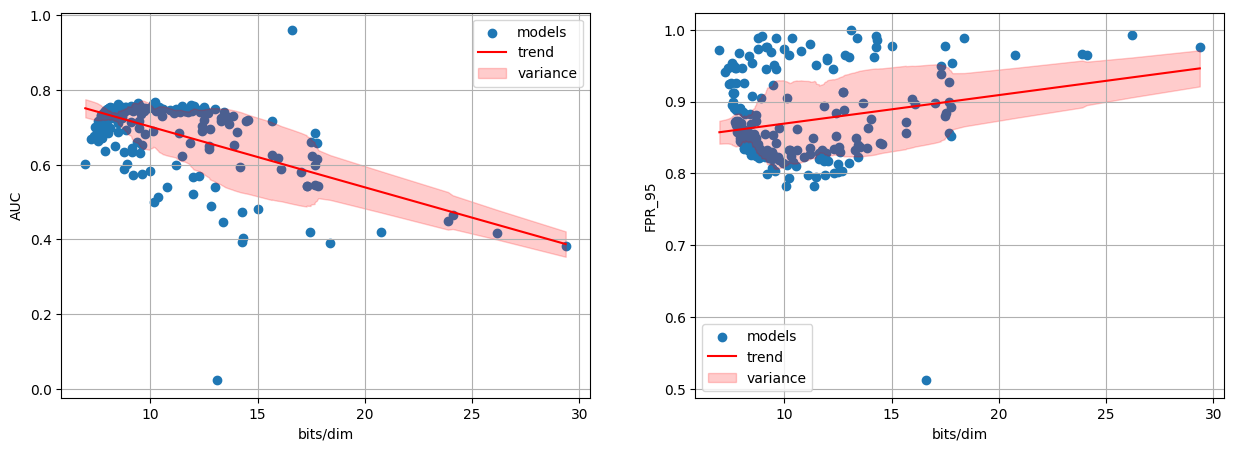

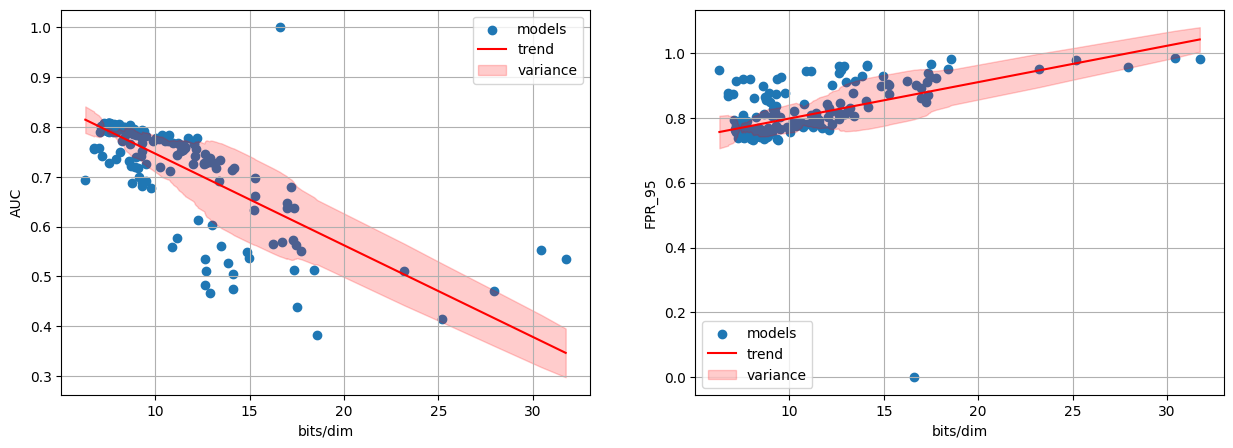

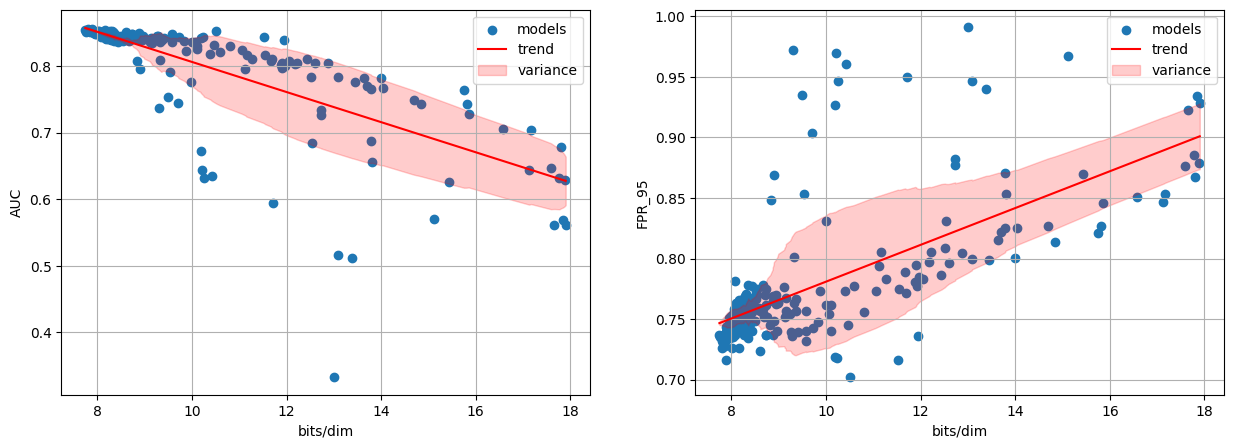

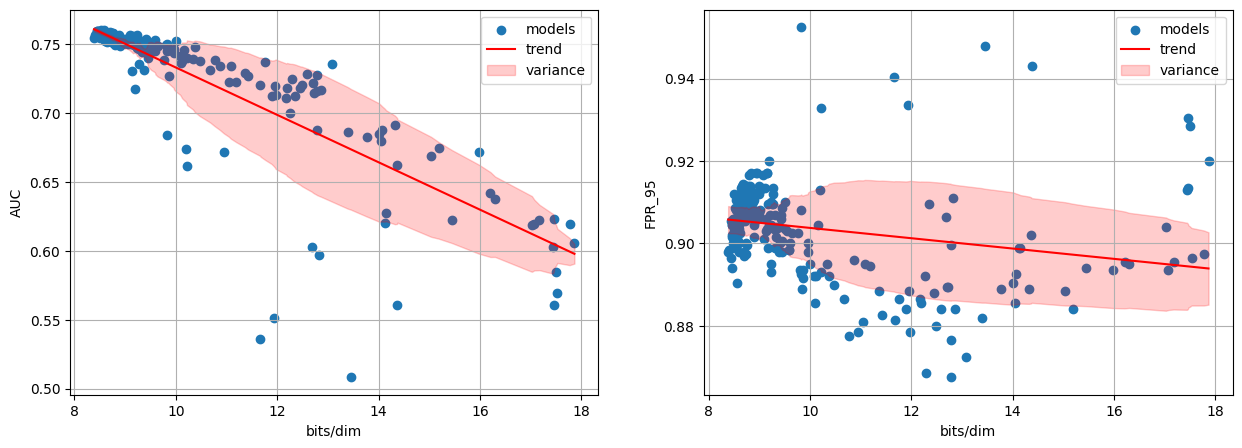

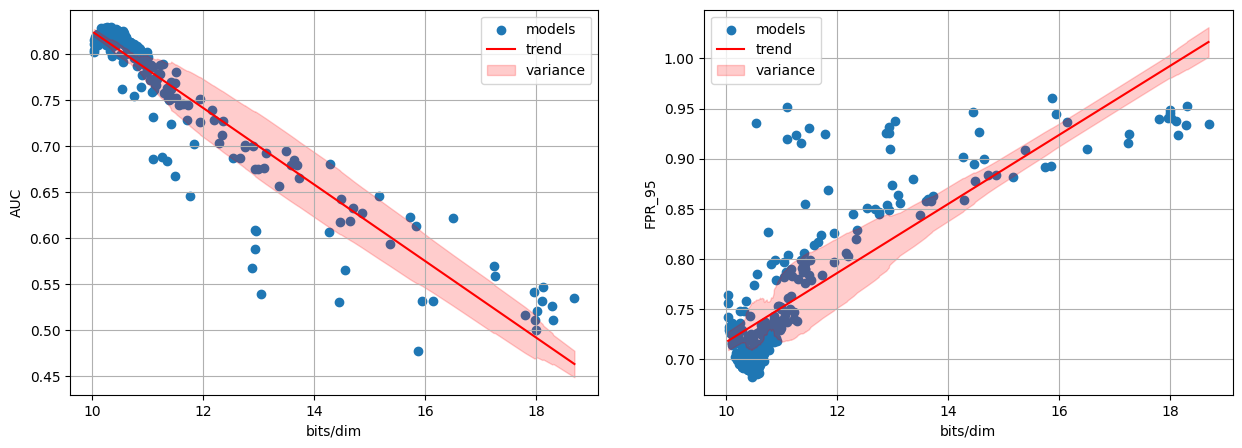

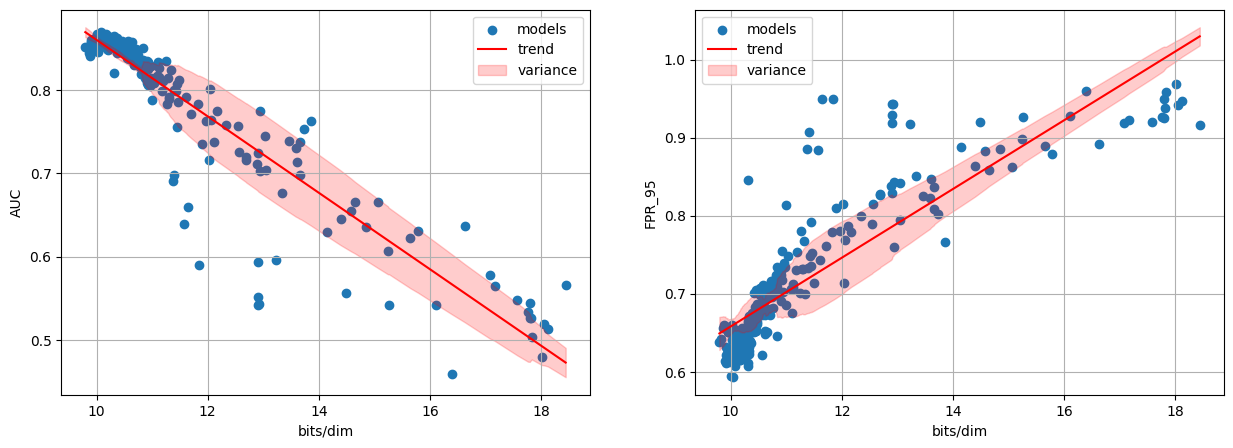

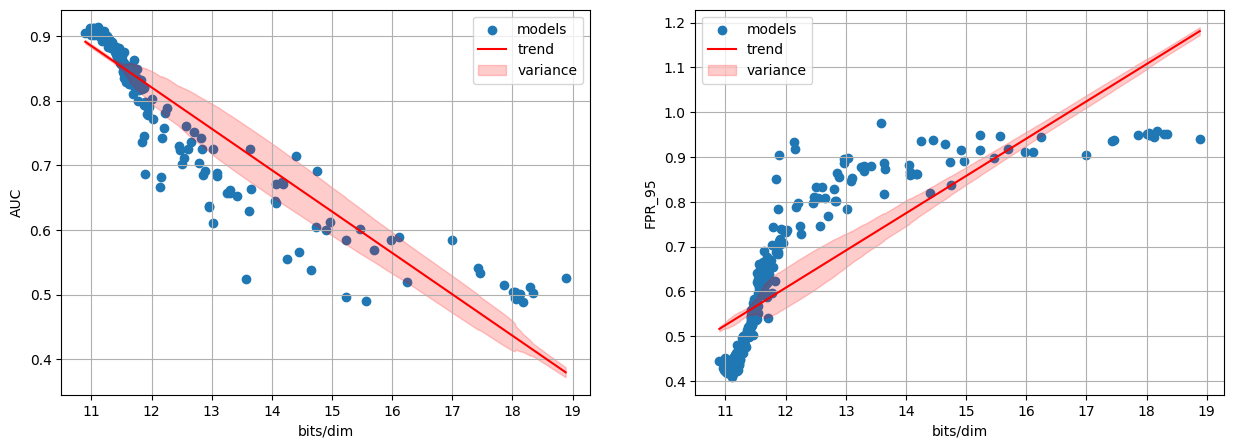

In [64]:
encoder_best_auc = {}
for encoder in ['repvgg', 'resnet50d', 'swin', 'deit', 'dino', 'dinov2', 'vit']:

    dataset = 'imagenet'

    intrests = ['n_epochs', 
                'bottleneck_channels', 
                'num_res_blocks', 
                'time_embed_dim', 
                'beta_min', 'beta_max',
                'lr',
                'dropout',
                'auc',
                f'{encoder}_{dataset}_score_ref',
                f'{encoder}_{dataset}_id_loss',
                f'{encoder}_{dataset}_nearood_imagenet-o_AUC',
                f'{encoder}_{dataset}_nearood_imagenet-o_FPR_95',
                ]

    np_values = {k: np.array([t[k] for t in values]) for k in intrests}

    # Example of plotting with sliding window variance
    figure = plt.figure(figsize=(15, 5))
    # figure.suptitle(f'{encoder}')

    index = np.argsort(np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'])
    params = {}
    for i in range(3):
        for p, v in trials[index[-i]].params.items():
            if p not in params:
                params[p] = []
            params[p].append(v)
    encoder_best_auc[encoder] = np.mean(np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][index[-10:]]), params

    loss = np_values[f'{encoder}_{dataset}_id_loss'] < 1000
    # Create subplots and apply the sliding window variance function
    ax = figure.add_subplot(121)
    plot_with_sliding_window_variance(ax, np_values[f'{encoder}_{dataset}_score_ref'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'bits/dim', 'AUC', '')
    ax = figure.add_subplot(122)
    plot_with_sliding_window_variance(ax, np_values[f'{encoder}_{dataset}_score_ref'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_FPR_95'][loss], 'bits/dim', 'FPR_95', '')
    # ax = figure.add_subplot(333)
    # plot_with_sliding_window_variance(ax, np_values[f'lr'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'lr', 'auc', 'lr vs auc')
    # ax = figure.add_subplot(334)
    # plot_with_sliding_window_variance(ax, np_values[f'beta_min'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'beta_min', 'auc', 'beta_min vs auc')
    # ax = figure.add_subplot(335)
    # plot_with_sliding_window_variance(ax, np_values[f'beta_max'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'beta_max', 'auc', 'beta_max vs auc')
    # ax = figure.add_subplot(336)
    # plot_with_sliding_window_variance(ax, np_values[f'dropout'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'dropout', 'auc', 'dropout vs auc')
    # ax = figure.add_subplot(337)
    # plot_with_sliding_window_variance(ax, np_values[f'time_embed_dim'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'time_embed_dim', 'auc', 'time_embed_dim vs auc')
    # ax = figure.add_subplot(338)
    # plot_with_sliding_window_variance(ax, np_values[f'bottleneck_channels'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'bottleneck_channels', 'auc', 'bottleneck_channels vs auc')
    # ax = figure.add_subplot(339)
    # plot_with_sliding_window_variance(ax, np_values[f'num_res_blocks'][loss], np_values[f'{encoder}_{dataset}_nearood_imagenet-o_AUC'][loss], 'num_res_blocks', 'auc', 'num_res_blocks vs auc')

    plt.savefig(f'{encoder}.png')



plt.show()

In [60]:
for encoder, (auc, conf) in sorted(encoder_best_auc.items(), key=lambda x: x[1], reverse=True):
    print(f"{encoder}: {auc:.1%}")
    for k, v in conf.items():
        print(f"    {k}: {np.mean(v):.3f}, {v}")

vit: 91.2%
    n_epochs: 366.667, [500, 300, 300]
    bottleneck_channels: 853.333, [256, 1792, 512]
    num_res_blocks: 6.000, [9, 6, 3]
    time_embed_dim: 341.333, [512, 256, 256]
    dropout: 0.222, [0.20507666213092263, 0.24317537435908987, 0.21856901360140613]
    lr: 0.004, [1.2184911425255087e-06, 0.003413265727580557, 0.009921410750025034]
    likelihood_weighting: 1.000, [True, True, True]
    reduce_mean: 0.333, [False, True, False]
    beta_min: 0.453, [0.7707111985158176, 0.04509669122298443, 0.5434724083688577]
    beta_max: 15.000, [15, 20, 10]
dinov2: 86.6%
    n_epochs: 200.000, [100, 300, 200]
    bottleneck_channels: 1109.333, [512, 1792, 1024]
    num_res_blocks: 7.667, [3, 11, 9]
    time_embed_dim: 512.000, [256, 1024, 256]
    dropout: 0.289, [0.19047268055467803, 0.323222360975637, 0.35343530173117726]
    lr: 0.003, [0.00827849803876892, 6.139565305858912e-05, 0.00036565887340390897]
    likelihood_weighting: 0.667, [True, False, True]
    reduce_mean: 0.333, [